In [0]:
#Import dependencies
import cv2
import numpy as np

In [0]:
#Set Spark conf to access ADLS
spark.conf.set(f"fs.azure.account.auth.type.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", f"{dbutils.secrets.get('storageaccount', 'sastoken')}")

In [0]:
#Read image from ADLS as Spark DF
df = spark.read.format("image").load(f"abfss://nga-ml@{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net/messy_living_room.jpg")

In [0]:
#Show image metadata
df.select("image.height", "image.width"
         ,"image.nChannels", "image.mode"
         ,"image.data").show()

+------+-----+---------+----+--------------------+
|height|width|nChannels|mode|                data|
+------+-----+---------+----+--------------------+
|   360|  540|        3|  16|[F0 EB ED DB DE E...|
+------+-----+---------+----+--------------------+



In [0]:
#Convert bytearray to numpy ndarray
img_array = np.array(df.select('image.data').collect()[0]['data'])

#Reshape numpy.ndarray to height x width x channels
img_array = img_array.reshape((360, 540, 3))

#Check shape
img_array.shape

Out[32]: (360, 540, 3)

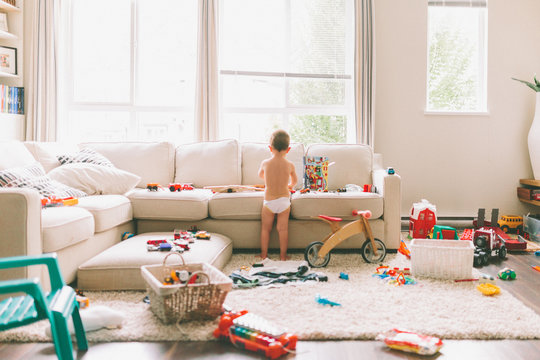

In [0]:
#View image
from dbruntime.patches import cv2_imshow
cv2_imshow(img_array)